## Donor's Choose Classification

## This notebook contains classification of Donor's choose dataset 

**Link to Dataset: https://www.kaggle.com/competitions/donorschoose-application-screening/data**

**Summary of experiments:**

Text preprocessing with w2v, average w2v with tfidf,BOW with decision trees.
This notebook also illustrates the advantages of using embeddings instead of traditional approaches such as BOW, Tfidf in certain situations for better classification.

<h1>1. Decision Tree </h1>

In [ ]:
#Importing necessary libraries

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from tqdm import tqdm_notebook as tqdm
from sklearn.preprocessing import MinMaxScaler

In [ ]:
# please write all the code with proper documentation, and proper titles for each subsection
# go through documentations and blogs before you start coding 
# first figure out what to do, and then think about how to do.
# reading and understanding error messages will be very much helpfull in debugging your code
# make sure you featurize train and test data separatly

# when you plot any graph make sure you use 
    # a. Title, that describes your plot, this will be very helpful to the reader
    # b. Legends if needed
    # c. X-axis label
    # d. Y-axis label

## 1.1 Loading Data

In [ ]:
import pandas
data = pandas.read_csv('preprocessed_data.csv')

In [ ]:
# Separating the class( project is approved ) from the rest of the Data.
y = data['project_is_approved'].values
X = data.drop(['project_is_approved'], axis=1)
X.head(3)

school_state teacher_prefix project_grade_category  \
0           ca            mrs          grades_prek_2   
1           ut             ms             grades_3_5   
2           ca            mrs          grades_prek_2   

   teacher_number_of_previously_posted_projects   clean_categories  \
0                                            53       math_science   
1                                             4       specialneeds   
2                                            10  literacy_language   

                  clean_subcategories  \
0  appliedsciences health_lifescience   
1                        specialneeds   
2                            literacy   

                                               essay   price  
0  i fortunate enough use fairy tale stem kits cl...  725.05  
1  imagine 8 9 years old you third grade classroo...  213.03  
2  having class 24 students comes diverse learner...  329.00

<h2>1.2 Splitting data into Train and cross validation(or test): Stratified Sampling</h2>

In [ ]:
from sklearn.model_selection import train_test_split   # Splitting data into train , cv and test 
X_train, X_test, y_train, y_test    =  train_test_split(X, y, test_size=0.33, stratify=y, random_state = 2)
X_train, X_cv, y_train, y_cv  =  train_test_split(X_train, y_train, test_size=0.33, stratify=y_train,  random_state = 2)

print(X_train.shape,y_train.shape)
print(X_cv.shape,y_cv.shape)
print(X_test.shape,y_test.shape)

(49041, 8) (49041,)
(24155, 8) (24155,)
(36052, 8) (36052,)


## Experiment 1 :

### Set 1 : ( TFIDF W2V)


In [ ]:
import pickle
with open('glove_vectors', 'rb') as f:
    model = pickle.load(f)
    glove_words =  set(model.keys())

In [ ]:
tfidf_model = TfidfVectorizer()
tfidf_model.fit(X_train['essay'].values)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())

# average Word2Vec
# compute average word2vec for each review.

def tfidf_w2v_Vectorizer(preprocessed_essays):
    ''' Input :  takes in preprocessed data in string format
        Returns : The tfidf_w2v array
    '''
    tfidf_w2v_vectors = []; # the avg-w2v for each sentence/review is stored in this list
    for sentence in tqdm(preprocessed_essays): # for each review/sentence
        vector = np.zeros(300) # as word vectors are of zero length
        tf_idf_weight =0; # num of words with a valid vector in the sentence/review
        for word in sentence.split(): # for each word in a review/sentence
            if (word in glove_words) and (word in tfidf_words):
                vec = model[word] # getting the vector for each word
                # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
                tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
                vector += (vec * tf_idf) # calculating tfidf weighted w2v
                tf_idf_weight += tf_idf
        if tf_idf_weight != 0:
            vector /= tf_idf_weight
        tfidf_w2v_vectors.append(vector)
        
    return tfidf_w2v_vectors

In [ ]:
X_train_tfidf_w2v_essay = tfidf_w2v_Vectorizer(X_train['essay'].values)
X_cv_tfidf_w2v_essay = tfidf_w2v_Vectorizer(X_cv['essay'].values )
X_test_tfidf_w2v_essay = tfidf_w2v_Vectorizer(X_test['essay'].values)

### Encoding Categorical features ::

#### School State::

In [ ]:
# Creating a Vectorizer object
# This creates a vocabulary on the Train data, and based on this , the test and the cv set is transformed.
vectorizer = CountVectorizer()
vectorizer.fit(X_train['school_state'].values)

X_train_state_encoded = vectorizer.transform(X_train['school_state'].values)
X_cv_state_encoded = vectorizer.transform(X_cv['school_state'].values)
X_test_state_encoded = vectorizer.transform(X_test['school_state'].values)


school_vocab = list(vectorizer.vocabulary_) # Store the vocabulary for later use

print('**'*20)
print("After Encoding (One hot encoding)")
print('**'*20)
print(X_train_state_encoded.shape, y_train.shape)
print(X_cv_state_encoded.shape, y_cv.shape)
print(X_test_state_encoded.shape, y_test.shape)
print('**'*20)
print('**'*20)
print('The Feature Names are :: ')
print(vectorizer.get_feature_names())
print('**'*20)
print('**'*20)
print(' Sample of one hot encoding on Test data ::')
print(X_test_state_encoded.toarray()[8])
print('**'*20)
print('**'*20)


****************************************
After Encoding (One hot encoding)
****************************************
(49041, 51) (49041,)
(24155, 51) (24155,)
(36052, 51) (36052,)
****************************************
****************************************
The Feature Names are :: 
['ak', 'al', 'ar', 'az', 'ca', 'co', 'ct', 'dc', 'de', 'fl', 'ga', 'hi', 'ia', 'id', 'il', 'in', 'ks', 'ky', 'la', 'ma', 'md', 'me', 'mi', 'mn', 'mo', 'ms', 'mt', 'nc', 'nd', 'ne', 'nh', 'nj', 'nm', 'nv', 'ny', 'oh', 'ok', 'or', 'pa', 'ri', 'sc', 'sd', 'tn', 'tx', 'ut', 'va', 'vt', 'wa', 'wi', 'wv', 'wy']
****************************************
****************************************
 Sample of one hot encoding on Test data ::
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
****************************************
****************************************


#### 2) Encoding teacher prefix


In [ ]:
# Creating a Vectorizer object
# This creates a vocabulary on the Train data, and based on this , the test and the cv set is transformed.

vectorizer = CountVectorizer()
vectorizer.fit(X_train['teacher_prefix'].values)

X_train_teacher_encoded = vectorizer.transform(X_train['teacher_prefix'].values)
X_cv_teacher_encoded= vectorizer.transform(X_cv['teacher_prefix'].values)
X_test_teacher_encoded = vectorizer.transform(X_test['teacher_prefix'].values)

teacher_prefix_vocab = list(vectorizer.vocabulary_)  # Store the vocabulary for later use

print('**'*20)
print("After Encoding (One hot encoding)")
print('**'*20)
print(X_train_teacher_encoded.shape, y_train.shape)
print(X_cv_teacher_encoded.shape, y_cv.shape)
print(X_test_teacher_encoded.shape, y_test.shape)
print('**'*20)
print('**'*20)
print('The Feature Names are :: ')
print(vectorizer.get_feature_names())
print('**'*20)
print('**'*20)
print(' Sample of one hot encoding on Test data ::')
print(X_test_teacher_encoded.toarray()[8])
print('**'*20)
print('**'*20)

****************************************
After Encoding (One hot encoding)
****************************************
(49041, 5) (49041,)
(24155, 5) (24155,)
(36052, 5) (36052,)
****************************************
****************************************
The Feature Names are :: 
['dr', 'mr', 'mrs', 'ms', 'teacher']
****************************************
****************************************
 Sample of one hot encoding on Test data ::
[0 0 1 0 0]
****************************************
****************************************


#### 3) Encoding project_grade_category


In [ ]:
# Creating a Vectorizer object
# This creates a vocabulary on the Train data, and based on this , the test and the cv set is transformed.

vectorizer = CountVectorizer()
vectorizer.fit(X_train['project_grade_category'].values)

X_train_grade_encoded = vectorizer.transform(X_train['project_grade_category'].values)
X_cv_grade_encoded = vectorizer.transform(X_cv['project_grade_category'].values)
X_test_grade_encoded = vectorizer.transform(X_test['project_grade_category'].values)


project_grade_vocab = list(vectorizer.vocabulary_)   # Store the vocabulary for later use

print('**'*20)
print("After Encoding (One hot encoding)")
print('**'*20)
print(X_train_grade_encoded.shape, y_train.shape)
print(X_cv_grade_encoded.shape, y_cv.shape)
print(X_test_grade_encoded.shape, y_test.shape)
print('**'*20)
print('**'*20)
print('The Feature Names are :: ')
print(vectorizer.get_feature_names())
print('**'*20)
print('**'*20)
print(' Sample of one hot encoding on Test data ::')
print(X_test_grade_encoded.toarray()[1])
print('**'*20)
print('**'*20)

****************************************
After Encoding (One hot encoding)
****************************************
(49041, 4) (49041,)
(24155, 4) (24155,)
(36052, 4) (36052,)
****************************************
****************************************
The Feature Names are :: 
['grades_3_5', 'grades_6_8', 'grades_9_12', 'grades_prek_2']
****************************************
****************************************
 Sample of one hot encoding on Test data ::
[1 0 0 0]
****************************************
****************************************


#### 4) clean_categories

In [ ]:
# Creating a Vectorizer object
# This creates a vocabulary on the Train data, and based on this , the test and the cv set is transformed.

vectorizer = CountVectorizer()
vectorizer.fit(X_train['clean_categories'].values)

X_train_clean_categories_encoded = vectorizer.transform(X_train['clean_categories'].values)
X_cv_clean_categories_encoded = vectorizer.transform(X_cv['clean_categories'].values)
X_test_clean_categories_encoded = vectorizer.transform(X_test['clean_categories'].values)

clean_categories_vocab = list(vectorizer.vocabulary_)   # Store the vocabulary for later use

print('**'*20)
print("After Encoding (One hot encoding)")
print('**'*20)
print(X_train_clean_categories_encoded.shape, y_train.shape)
print(X_cv_clean_categories_encoded.shape, y_cv.shape)
print(X_test_clean_categories_encoded.shape, y_test.shape)
print('**'*20)
print('**'*20)
print('The Feature Names are :: ')
print(vectorizer.get_feature_names())
print('**'*20)
print('**'*20)
print(' Sample of one hot encoding on Test data ::')
print(X_test_clean_categories_encoded.toarray()[1])
print('**'*20)
print('**'*20)

****************************************
After Encoding (One hot encoding)
****************************************
(49041, 9) (49041,)
(24155, 9) (24155,)
(36052, 9) (36052,)
****************************************
****************************************
The Feature Names are :: 
['appliedlearning', 'care_hunger', 'health_sports', 'history_civics', 'literacy_language', 'math_science', 'music_arts', 'specialneeds', 'warmth']
****************************************
****************************************
 Sample of one hot encoding on Test data ::
[1 0 0 0 0 0 0 0 0]
****************************************
****************************************


#### 5) clean_subcategories


In [ ]:

# Creating a Vectorizer object
# This creates a vocabulary on the Train data, and based on this , the test and the cv set is transformed.

vectorizer = CountVectorizer()
vectorizer.fit(X_train['clean_subcategories'].values)

X_train_clean_sub_categories_encoded = vectorizer.transform(X_train['clean_subcategories'].values)
X_cv_clean_sub_categories_encoded = vectorizer.transform(X_cv['clean_subcategories'].values)
X_test_clean_sub_categories_encoded = vectorizer.transform(X_test['clean_subcategories'].values)


clean_sub_categories_vocab = list(vectorizer.vocabulary_)   # Store the vocabulary for later use

print('**'*20)
print("After Encoding (One hot encoding)")
print('**'*20)
print(X_train_clean_sub_categories_encoded.shape, y_train.shape)
print(X_cv_clean_sub_categories_encoded.shape, y_cv.shape)
print(X_test_clean_sub_categories_encoded.shape, y_test.shape)
print('**'*20)
print('**'*20)
print('The Feature Names are :: ')
print(vectorizer.get_feature_names())
print('**'*20)
print('**'*20)
print(' Sample of one hot encoding on Test data ::')
print(X_test_clean_sub_categories_encoded.toarray()[1])
print('**'*20)
print('**'*20)

****************************************
After Encoding (One hot encoding)
****************************************
(49041, 30) (49041,)
(24155, 30) (24155,)
(36052, 30) (36052,)
****************************************
****************************************
The Feature Names are :: 
['appliedsciences', 'care_hunger', 'charactereducation', 'civics_government', 'college_careerprep', 'communityservice', 'earlydevelopment', 'economics', 'environmentalscience', 'esl', 'extracurricular', 'financialliteracy', 'foreignlanguages', 'gym_fitness', 'health_lifescience', 'health_wellness', 'history_geography', 'literacy', 'literature_writing', 'mathematics', 'music', 'nutritioneducation', 'other', 'parentinvolvement', 'performingarts', 'socialsciences', 'specialneeds', 'teamsports', 'visualarts', 'warmth']
****************************************
****************************************
 Sample of one hot encoding on Test data ::
[0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
****

### Encoding Numerical Features


#### 1) Teacher_number_of_previously_posted_projects


In [ ]:
#Some sample data

X_train['teacher_number_of_previously_posted_projects'][:3]

#Normalizing data using the Minmax scalar()
# Standardizing price does not make more sense, as the resultant may be having negative values.

scaler = MinMaxScaler()

scaler.fit(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1, 1))

X_train_teacher_previously_submitted_number_normalized = scaler.transform(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1, 1))
X_cv_teacher_previously_submitted_number_normalized  = scaler.transform(X_cv['teacher_number_of_previously_posted_projects'].values.reshape(-1, 1))
X_test_teacher_previously_submitted_number_normalized  = scaler.transform(X_test['teacher_number_of_previously_posted_projects'].values.reshape(-1, 1))

print('X_train shape :: ',X_train_teacher_previously_submitted_number_normalized.shape)
print('X_cv shape :: ',X_cv_teacher_previously_submitted_number_normalized.shape)
print('X_test shape :: ',X_test_teacher_previously_submitted_number_normalized.shape)

X_train shape ::  (49041, 1)
X_cv shape ::  (24155, 1)
X_test shape ::  (36052, 1)


#### 2) price


In [ ]:
#Normalizing data using the Minmax scalar()
# Standardizing price does not make more sense, as the resultant may be having negative values.

scaler = MinMaxScaler()
scaler.fit(X_train['price'].values.reshape(-1, 1))

X_train_price_norm = scaler.transform(X_train['price'].values.reshape(-1,1))
X_cv_price_norm = scaler.transform(X_cv['price'].values.reshape(-1,1))
X_test_price_norm = scaler.transform(X_test['price'].values.reshape(-1,1))

print('X_train shape :: ',X_train_price_norm.shape)
print('X_cv shape :: ' , X_cv_price_norm.shape)
print('X_test shape::' , X_test_price_norm.shape)


X_train shape ::  (49041, 1)
X_cv shape ::  (24155, 1)
X_test shape:: (36052, 1)


### Concatenating all features


In [ ]:
from scipy.sparse import hstack,vstack

X_tr = hstack((X_train_tfidf_w2v_essay,  X_train_state_encoded,  X_train_teacher_encoded,  X_train_grade_encoded, X_train_teacher_previously_submitted_number_normalized,X_train_clean_categories_encoded,X_train_clean_sub_categories_encoded , X_train_price_norm)).tocsr()
X_cr = hstack((X_cv_tfidf_w2v_essay, X_cv_state_encoded, X_cv_teacher_encoded, X_cv_grade_encoded, X_cv_teacher_previously_submitted_number_normalized, X_cv_clean_categories_encoded , X_cv_clean_sub_categories_encoded  , X_cv_price_norm)).tocsr()
X_te = hstack((X_test_tfidf_w2v_essay, X_test_state_encoded, X_test_teacher_encoded, X_test_grade_encoded, X_test_teacher_previously_submitted_number_normalized, X_test_clean_categories_encoded  ,X_test_clean_sub_categories_encoded  ,X_test_price_norm)).tocsr()


### 2) Hyper paramter tuning 

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score
train_auc = []                # A list to hold the train auc scores for different alpha
cv_auc = []                     # A list to hold the test auc scores for different alpha 

max_depth_range = [1, 5, 10, 50]
min_samples_split =  [5, 10, 100, 500]

for depth, samples_split  in tqdm( zip(max_depth_range ,min_samples_split) ):                                                                   # Iterate through all the  values
    
    clf = DecisionTreeClassifier(max_depth = depth,  min_samples_split = samples_split, class_weight= 'balanced' )    # weight =  balanced   because of imbalanced data
    clf.fit(X_tr, y_train)
    
    y_train_pred =  clf.predict_proba(X_tr) [:,1]                                                        # Predict on Train set
    y_cv_pred = clf.predict_proba(X_cr)[:,1]                                                               # Predict of Test set
    
    train_auc.append(roc_auc_score(y_train,y_train_pred))                            # Append the scores to the appropriate lists.
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))


print('Train Auc  :: ', train_auc)
print('Cv Auc :: ', cv_auc)



Train Auc  ::  [0.5465747540416316, 0.656770688139153, 0.7810117359962119, 0.7546919149311534]
Cv Auc ::  [0.5461627501464559, 0.6257455091492283, 0.6118432611244972, 0.612331213649688]


### 3) Representation of Results::


In [ ]:
import plotly.offline as offline
import plotly.graph_objs as go
import numpy as np

x1 = min_samples_split
y1 = max_depth_range
z1 = train_auc

z2 = cv_auc

# https://plot.ly/python/3d-axes/
trace1 = go.Scatter3d(x=x1,y=y1,z=z1, name = 'Train',  line=dict(color="#ff0000"))  # ff 00 00 (is in format of RGB)
trace2 = go.Scatter3d(x=x1,y=y1,z=z2, name = 'Cross Validation', line=dict(color="#0000ff") ) # blue color
data1 = [trace1, trace2]

layout = go.Layout(scene = dict(
        xaxis = dict(title='min_sample_split'),
        yaxis = dict(title='max_depth'),
        zaxis = dict(title='AUC (Tfidf)')))

fig = go.Figure(data=data1, layout=layout)
offline.iplot(fig, filename='3d-scatter-colorscale')

In [ ]:
best_depth = 5
best_split = 10

#### Training Train data set on the best parameter


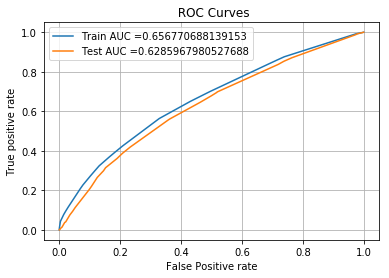

In [ ]:
clf = DecisionTreeClassifier( max_depth=best_depth  ,min_samples_split=best_split , class_weight= 'balanced' )
clf.fit(X_tr,y_train)
 
y_train_pred = clf.predict_proba(X_tr)[:,1]     
y_test_pred = clf.predict_proba(X_te)[:,1]

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("False Positive rate")
plt.ylabel("True positive rate")
plt.title(" ROC Curves")
plt.grid()
plt.show()

In [ ]:
def best_threshold(threshold, fpr, tpr):
    ''' Input :: 
        Threshold :: the Threshold array as the result of the calculation of the auc score.
        fpr:  False positve rate array
        tpr:  True positive rate array
        
        Returns:
        The  best threshold
    '''
    t = threshold[np.argmax(tpr*(1-fpr))]   # Get the threshold  which is least impacted by  false positive rates, as we want less fpr.
    print('='*80)
    print("the maximum value of tpr*(1-fpr) ::", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    print('='*80)
    return t

def predict_with_best_threshold(predicted_array , threshold):
    '''
    Input::
    Theshold : Takes in a threshold.
    predicted array : the output of the classifier (an array of probability values)
    '''
    predictions = []
    for i in predicted_array:
        if i>=threshold:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions


In [ ]:
from sklearn.metrics import confusion_matrix
best_t = best_threshold(tr_thresholds, train_fpr, train_tpr)
y_pred_with_best_t = predict_with_best_threshold(y_test_pred, best_t)
print('='*80)
print("Train confusion matrix")
print('='*80)
print(confusion_matrix(y_train, predict_with_best_threshold(y_train_pred, best_t)))
print('='*80)
print("Test confusion matrix")
print('='*80)
print(confusion_matrix(y_test, predict_with_best_threshold(y_test_pred, best_t)))
print('='*80)

the maximum value of tpr*(1-fpr) :: 0.3784895975021954 for threshold 0.465
Train confusion matrix
[[ 4948  2478]
 [17976 23639]]
Test confusion matrix
[[ 3478  1981]
 [13424 17169]]


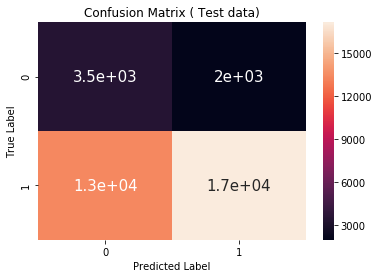

In [ ]:

matrix2 = confusion_matrix(y_test, predict_with_best_threshold(y_test_pred, best_t))
sns.heatmap(matrix2,annot=True, annot_kws={"size": 15},cbar=True)
plt.ylabel('True Label');
plt.xlabel('Predicted Label');
plt.title('Confusion Matrix ( Test data)');

all_false_positive = []
for e in range(len(y_test)):
    if y_test[e] == 0 and y_pred_with_best_t[e] ==1 :
        all_false_positive.append(e)


In [ ]:

essay_falsepositive = []
price_falsepositive = []
teacher_previous_posted_falsepositive = []

for e in tqdm(all_false_positive) :
    essay_falsepositive.append(data['essay'].values[e])
    price_falsepositive.append( list(data['price'].values)[e] )
    teacher_previous_posted_falsepositive.append( list( data['teacher_number_of_previously_posted_projects'].values)[e])


#### Plot Word Cloud ::


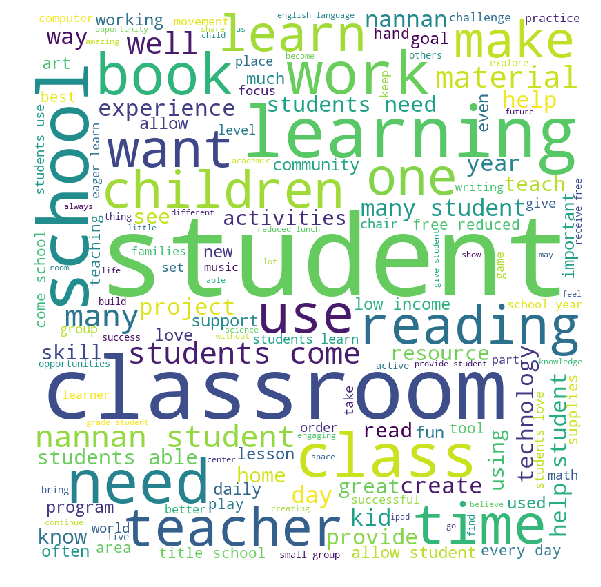

In [ ]:
from wordcloud import WordCloud,STOPWORDS
import matplotlib.pyplot as plt 
stopwords = set(STOPWORDS)
wordcloud = WordCloud(width = 800, height = 800, 
            background_color ='white', 
            stopwords = stopwords,    #By default, stopwords will be built in STOPWORDS
            min_font_size = 10).generate(' '.join(essay_falsepositive))   # joins all the essay related to false positives and then gives the wordcloud

# plot the WordCloud                         
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show()


#### Box plot of prices in false positives :


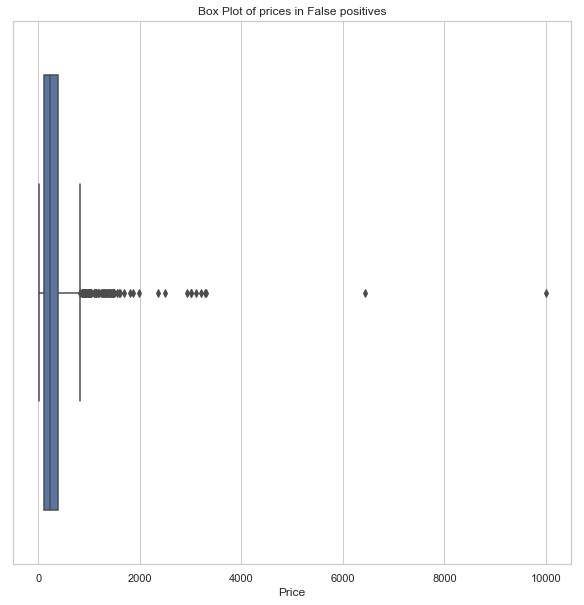

In [ ]:
plt.figure(figsize=(10,10))
sns.set(style="whitegrid")
ax = sns.boxplot(x=price_falsepositive)
ax.set(xlabel='Price', title='Box Plot of prices in False positives')
plt.show()


#### PDF of teacher_number_of_previously_posted_projects ::


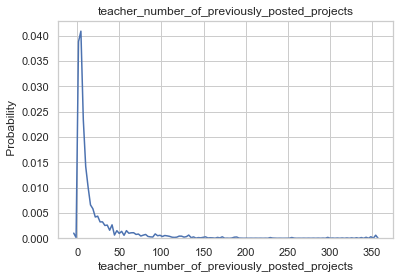

In [ ]:
ax = sns.kdeplot(teacher_previous_posted_falsepositive, cumulative= False)
ax.set(xlabel='teacher_number_of_previously_posted_projects', ylabel=' Probability', title='teacher_number_of_previously_posted_projects')
plt.show()

### Experiment 2 (TFIDF) ::

### Encoding Essay

In [ ]:
vectorizer = TfidfVectorizer(min_df = 5 , ngram_range=(1,2),  max_features=2000)
vectorizer.fit(X_train['essay'].values) 

X_train_essay_tfidf = vectorizer.transform(X_train['essay'].values)
X_cv_essay_tfidf = vectorizer.transform(X_cv['essay'].values)
X_test_essay_tfidf = vectorizer.transform(X_test['essay'].values)

In [ ]:
print("After vectorizations")
print(X_train_essay_tfidf.shape, y_train.shape)
print(X_cv_essay_tfidf.shape, y_cv.shape)
print(X_test_essay_tfidf.shape, y_test.shape)

After vectorizations
(49041, 2000) (49041,)
(24155, 2000) (24155,)
(36052, 2000) (36052,)


In [ ]:
essay_vocab = list(vectorizer.vocabulary_.keys())  # vocab of essay !

<h2>1.4 Make Data Model Ready: encoding numerical, categorical features</h2>

### Encoding Categorical Features ::

#### 1) Encoding school_state


In [ ]:
# Creating a Vectorizer object.
# This creates a vocabulary on the Train data, and based on this , the test and the cv set is transformed.

vectorizer = TfidfVectorizer()
vectorizer.fit(X_train['school_state'].values)

X_train_state_encoded_tfidf = vectorizer.transform(X_train['school_state'].values)
X_cv_state_encoded_tfidf = vectorizer.transform(X_cv['school_state'].values)
X_test_state_encoded_tfidf = vectorizer.transform(X_test['school_state'].values)

print('**'*20)
print("After Encoding (One hot encoding)")
print('**'*20)
print(X_train_state_encoded_tfidf.shape, y_train.shape)
print(X_cv_state_encoded_tfidf.shape, y_cv.shape)
print(X_test_state_encoded_tfidf.shape, y_test.shape)
print('**'*20)
print('**'*20)
print('The Feature Names are :: ')
print(vectorizer.get_feature_names())
print('**'*20)
print('**'*20)
print(' Sample of one hot encoding on Test data ::')
print(X_test_state_encoded_tfidf.toarray()[8])
print('**'*20)
print('**'*20)



****************************************
After Encoding (One hot encoding)
****************************************
(49041, 51) (49041,)
(24155, 51) (24155,)
(36052, 51) (36052,)
****************************************
****************************************
The Feature Names are :: 
['ak', 'al', 'ar', 'az', 'ca', 'co', 'ct', 'dc', 'de', 'fl', 'ga', 'hi', 'ia', 'id', 'il', 'in', 'ks', 'ky', 'la', 'ma', 'md', 'me', 'mi', 'mn', 'mo', 'ms', 'mt', 'nc', 'nd', 'ne', 'nh', 'nj', 'nm', 'nv', 'ny', 'oh', 'ok', 'or', 'pa', 'ri', 'sc', 'sd', 'tn', 'tx', 'ut', 'va', 'vt', 'wa', 'wi', 'wv', 'wy']
****************************************
****************************************
 Sample of one hot encoding on Test data ::
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0.]
****************************************
****************************************


In [ ]:
school_vocab = list(vectorizer.vocabulary_)

#### 2) Encoding teacher prefix

In [ ]:
# Creating a Vectorizer object
# This creates a vocabulary on the Train data, and based on this , the test and the cv set is transformed.

vectorizer = CountVectorizer()
vectorizer.fit(X_train['teacher_prefix'].values)

X_train_teacher_encoded_tfidf = vectorizer.transform(X_train['teacher_prefix'].values)
X_cv_teacher_encoded_tfidf = vectorizer.transform(X_cv['teacher_prefix'].values)
X_test_teacher_encoded_tfidf = vectorizer.transform(X_test['teacher_prefix'].values)

teacher_prefix_vocab = list(vectorizer.vocabulary_)  # Store the vocabulary for later use

In [ ]:
print('**'*20)
print("After Encoding (One hot encoding)")
print('**'*20)
print(X_train_teacher_encoded_tfidf.shape, y_train.shape)
print(X_cv_teacher_encoded_tfidf.shape, y_cv.shape)
print(X_test_teacher_encoded_tfidf.shape, y_test.shape)
print('**'*20)
print('**'*20)
print('The Feature Names are :: ')
print(vectorizer.get_feature_names())
print('**'*20)
print('**'*20)
print(' Sample of one hot encoding on Test data ::')
print(X_test_teacher_encoded_tfidf.toarray()[8])
print('**'*20)
print('**'*20)

****************************************
After Encoding (One hot encoding)
****************************************
(49041, 5) (49041,)
(24155, 5) (24155,)
(36052, 5) (36052,)
****************************************
****************************************
The Feature Names are :: 
['dr', 'mr', 'mrs', 'ms', 'teacher']
****************************************
****************************************
 Sample of one hot encoding on Test data ::
[0 0 1 0 0]
****************************************
****************************************


#### 3) Encoding project_grade_category

In [ ]:
# Creating a Vectorizer object
# This creates a vocabulary on the Train data, and based on this , the test and the cv set is transformed.

vectorizer = CountVectorizer()
vectorizer.fit(X_train['project_grade_category'].values)

X_train_grade_encoded_tfidf = vectorizer.transform(X_train['project_grade_category'].values)
X_cv_grade_encoded_tfidf = vectorizer.transform(X_cv['project_grade_category'].values)
X_test_grade_encoded_tfidf = vectorizer.transform(X_test['project_grade_category'].values)


project_grade_vocab = list(vectorizer.vocabulary_)   # Store the vocabulary for later use

In [ ]:
print('**'*20)
print("After Encoding (One hot encoding)")
print('**'*20)
print(X_train_grade_encoded_tfidf.shape, y_train.shape)
print(X_cv_grade_encoded_tfidf.shape, y_cv.shape)
print(X_test_grade_encoded_tfidf.shape, y_test.shape)
print('**'*20)
print('**'*20)
print('The Feature Names are :: ')
print(vectorizer.get_feature_names())
print('**'*20)
print('**'*20)
print(' Sample of one hot encoding on Test data ::')
print(X_test_grade_encoded_tfidf.toarray()[1])
print('**'*20)
print('**'*20)

****************************************
After Encoding (One hot encoding)
****************************************
(49041, 4) (49041,)
(24155, 4) (24155,)
(36052, 4) (36052,)
****************************************
****************************************
The Feature Names are :: 
['grades_3_5', 'grades_6_8', 'grades_9_12', 'grades_prek_2']
****************************************
****************************************
 Sample of one hot encoding on Test data ::
[1 0 0 0]
****************************************
****************************************


#### 4) clean_categories

In [ ]:
# Creating a Vectorizer object
# This creates a vocabulary on the Train data, and based on this , the test and the cv set is transformed.

vectorizer = CountVectorizer()
vectorizer.fit(X_train['clean_categories'].values)

X_train_clean_categories_encoded_tfidf = vectorizer.transform(X_train['clean_categories'].values)
X_cv_clean_categories_encoded_tfidf = vectorizer.transform(X_cv['clean_categories'].values)
X_test_clean_categories_encoded_tfidf = vectorizer.transform(X_test['clean_categories'].values)

clean_categories_vocab = list(vectorizer.vocabulary_)   # Store the vocabulary for later use

In [ ]:
print('**'*20)
print("After Encoding (One hot encoding)")
print('**'*20)
print(X_train_clean_categories_encoded_tfidf.shape, y_train.shape)
print(X_cv_clean_categories_encoded_tfidf.shape, y_cv.shape)
print(X_test_clean_categories_encoded_tfidf.shape, y_test.shape)
print('**'*20)
print('**'*20)
print('The Feature Names are :: ')
print(vectorizer.get_feature_names())
print('**'*20)
print('**'*20)
print(' Sample of one hot encoding on Test data ::')
print(X_test_clean_categories_encoded_tfidf.toarray()[1])
print('**'*20)
print('**'*20)

****************************************
After Encoding (One hot encoding)
****************************************
(49041, 9) (49041,)
(24155, 9) (24155,)
(36052, 9) (36052,)
****************************************
****************************************
The Feature Names are :: 
['appliedlearning', 'care_hunger', 'health_sports', 'history_civics', 'literacy_language', 'math_science', 'music_arts', 'specialneeds', 'warmth']
****************************************
****************************************
 Sample of one hot encoding on Test data ::
[1 0 0 0 0 0 0 0 0]
****************************************
****************************************


#### 5) clean_subcategories

In [ ]:
# Creating a Vectorizer object
# This creates a vocabulary on the Train data, and based on this , the test and the cv set is transformed.

vectorizer = CountVectorizer()
vectorizer.fit(X_train['clean_subcategories'].values)

X_train_clean_sub_categories_encoded_tfidf = vectorizer.transform(X_train['clean_subcategories'].values)
X_cv_clean_sub_categories_encoded_tfidf = vectorizer.transform(X_cv['clean_subcategories'].values)
X_test_clean_sub_categories_encoded_tfidf = vectorizer.transform(X_test['clean_subcategories'].values)


clean_sub_categories_vocab = list(vectorizer.vocabulary_)   # Store the vocabulary for later use


In [ ]:
print('**'*20)
print("After Encoding (One hot encoding)")
print('**'*20)
print(X_train_clean_sub_categories_encoded_tfidf.shape, y_train.shape)
print(X_cv_clean_sub_categories_encoded_tfidf.shape, y_cv.shape)
print(X_test_clean_sub_categories_encoded_tfidf.shape, y_test.shape)
print('**'*20)
print('**'*20)
print('The Feature Names are :: ')
print(vectorizer.get_feature_names())
print('**'*20)
print('**'*20)
print(' Sample of one hot encoding on Test data ::')
print(X_test_clean_sub_categories_encoded_tfidf.toarray()[1])
print('**'*20)
print('**'*20)

****************************************
After Encoding (One hot encoding)
****************************************
(49041, 30) (49041,)
(24155, 30) (24155,)
(36052, 30) (36052,)
****************************************
****************************************
The Feature Names are :: 
['appliedsciences', 'care_hunger', 'charactereducation', 'civics_government', 'college_careerprep', 'communityservice', 'earlydevelopment', 'economics', 'environmentalscience', 'esl', 'extracurricular', 'financialliteracy', 'foreignlanguages', 'gym_fitness', 'health_lifescience', 'health_wellness', 'history_geography', 'literacy', 'literature_writing', 'mathematics', 'music', 'nutritioneducation', 'other', 'parentinvolvement', 'performingarts', 'socialsciences', 'specialneeds', 'teamsports', 'visualarts', 'warmth']
****************************************
****************************************
 Sample of one hot encoding on Test data ::
[0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
****

### Encoding Numerical Features

#### 1) Teacher_number_of_previously_posted_projects

In [ ]:
#Some sample data
X_train['teacher_number_of_previously_posted_projects'][:3]

75986     0
50828    38
87214    11
Name: teacher_number_of_previously_posted_projects, dtype: int64

In [ ]:
#Normalizing data using the Minmax scalar()
# Standardizing price does not make more sense, as the resultant may be having negative values.

scaler = MinMaxScaler()

scaler.fit(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1, 1))

X_train_teacher_previously_submitted_number_normalized = scaler.transform(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1, 1))
X_cv_teacher_previously_submitted_number_normalized  = scaler.transform(X_cv['teacher_number_of_previously_posted_projects'].values.reshape(-1, 1))
X_test_teacher_previously_submitted_number_normalized  = scaler.transform(X_test['teacher_number_of_previously_posted_projects'].values.reshape(-1, 1))

In [ ]:
print('X_train shape :: ',X_train_teacher_previously_submitted_number_normalized.shape)
print('X_cv shape :: ',X_cv_teacher_previously_submitted_number_normalized.shape)
print('X_test shape :: ',X_test_teacher_previously_submitted_number_normalized.shape)

X_train shape ::  (49041, 1)
X_cv shape ::  (24155, 1)
X_test shape ::  (36052, 1)


#### 2) price

In [ ]:
#Normalizing data using the Minmax scalar()
# Standardizing price does not make more sense, as the resultant may be having negative values.

scaler = MinMaxScaler()
scaler.fit(X_train['price'].values.reshape(-1, 1))

X_train_price_norm = scaler.transform(X_train['price'].values.reshape(-1,1))
X_cv_price_norm = scaler.transform(X_cv['price'].values.reshape(-1,1))
X_test_price_norm = scaler.transform(X_test['price'].values.reshape(-1,1))

In [ ]:
print('X_train shape :: ',X_train_price_norm.shape)
print('X_cv shape :: ' , X_cv_price_norm.shape)
print('X_test shape::' , X_test_price_norm.shape)

X_train shape ::  (49041, 1)
X_cv shape ::  (24155, 1)
X_test shape:: (36052, 1)


In [ ]:
### Concatenating all the features  and converting them to sparse format


In [ ]:
from scipy.sparse import hstack,vstack
# Concatenating all the features  and converting them to sparse format

X_tr = hstack((X_train_essay_tfidf,  X_train_state_encoded_tfidf,  X_train_teacher_encoded_tfidf,  X_train_grade_encoded_tfidf, X_train_teacher_previously_submitted_number_normalized,X_train_clean_categories_encoded_tfidf ,X_train_clean_sub_categories_encoded_tfidf , X_train_price_norm)).tocsr()
X_cr = hstack((X_cv_essay_tfidf, X_cv_state_encoded_tfidf, X_cv_teacher_encoded_tfidf, X_cv_grade_encoded_tfidf, X_cv_teacher_previously_submitted_number_normalized, X_cv_clean_categories_encoded_tfidf , X_cv_clean_sub_categories_encoded_tfidf  , X_cv_price_norm)).tocsr()
X_te = hstack((X_test_essay_tfidf, X_test_state_encoded_tfidf, X_test_teacher_encoded_tfidf, X_test_grade_encoded_tfidf, X_test_teacher_previously_submitted_number_normalized, X_test_clean_categories_encoded_tfidf  ,X_test_clean_sub_categories_encoded_tfidf  ,X_test_price_norm)).tocsr()


### 2)Hyper paramter tuning 

In [ ]:
# please write all the code with proper documentation, and proper titles for each subsection
# go through documentations and blogs before you start coding
# first figure out what to do, and then think about how to do.
# reading and understanding error messages will be very much helpfull in debugging your code
# when you plot any graph make sure you use 
    # a. Title, that describes your plot, this will be very helpful to the reader
    # b. Legends if needed
    # c. X-axis label
    # d. Y-axis label

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score
train_auc = []                # A list to hold the train auc scores
cv_auc = []                     # A list to hold the test auc scores

max_depth_range = [1, 5, 10, 50]
min_samples_split =  [5, 10, 100, 500]

for depth, samples_split  in tqdm( zip(max_depth_range ,min_samples_split) ):                                                                   # Iterate through all the  values
    
    clf = DecisionTreeClassifier(max_depth = depth,  min_samples_split = samples_split, class_weight = 'balanced')  # balanced
    clf.fit(X_tr, y_train)
    
    y_train_pred = clf.predict_proba( X_tr)[:,1]                                        # Predict on Train set
    y_cv_pred = clf.predict_proba( X_cr)[:,1]                                            # Predict of Test set
    
    train_auc.append(roc_auc_score(y_train,y_train_pred))         # Append the scores to the appropriate lists.
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))


In [ ]:
print('Train Auc  :: ', train_auc)
print('Cv Auc :: ', cv_auc)

Train Auc  ::  [0.5465747540416316, 0.6417970893657664, 0.717989163551762, 0.8432949084173829]
Cv Auc ::  [0.5461627501464559, 0.6240398864553717, 0.6405723756825299, 0.6168550214773816]


### 3) Representation of Results::

In [ ]:
import plotly.offline as offline
import plotly.graph_objs as go
import numpy as np

x1 = min_samples_split
y1 = max_depth_range
z1 = train_auc

z2 = cv_auc

# https://plot.ly/python/3d-axes/
trace1 = go.Scatter3d(x=x1,y=y1,z=z1, name = 'Train', surfacecolor= 'yellowgreen' , line=dict(color="#ff0000"))  # ff 00 00 (is in format of RGB)
trace2 = go.Scatter3d(x=x1,y=y1,z=z2, name = 'Cross Validation', line=dict(color="#0000ff") ) # blue color
data1 = [trace1, trace2]

layout = go.Layout(scene = dict(
        xaxis = dict(title='min_sample_split'),
        yaxis = dict(title='max_depth'),
        zaxis = dict(title='AUC (Tfidf)')))

fig = go.Figure(data=data1, layout=layout)
offline.iplot(fig, filename='3d-scatter-colorscale')

In [ ]:
best_depth = 5
best_split = 10

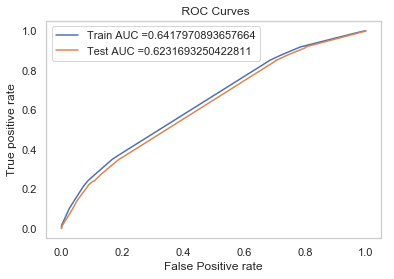

In [ ]:

# Training Train data set on the best parameter

clf = DecisionTreeClassifier( max_depth=best_depth  ,min_samples_split=best_split, class_weight='balanced'  )
clf.fit(X_tr,y_train)
 
y_train_pred = clf.predict_proba(X_tr)[:,1]   
y_test_pred = clf.predict_proba( X_te)[:,1]

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)   # Get the fpr and tpr and thresholds  For train and test data
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("False Positive rate")
plt.ylabel("True positive rate")
plt.title(" ROC Curves")
plt.grid()
plt.show()

#### Confusion matrix:

In [ ]:
def best_threshold(threshold, fpr, tpr):
    ''' Input :: 
        Threshold :: the Threshold array as the result of the calculation of the auc score.
        fpr:  False positve rate array
        tpr:  True positive rate array
        
        Returns:
        The  best threshold
    '''
    t = threshold[np.argmax(tpr*(1-fpr))]   # Get the treshold  which is least impacted by  false positive rates, as we want less fpr.
    print('='*80)
    print("the maximum value of tpr*(1-fpr) ::", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    print('='*80)
    return t

def predict_with_best_threshold(predicted_array , threshold):
    '''
    Input::
    Theshold : Takes in a threshold.
    predicted array : the output of the classifier (an array of probability values)
    '''
    predictions = []
    for i in predicted_array:
        if i>=threshold:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

In [ ]:
from sklearn.metrics import confusion_matrix
best_t = best_threshold(tr_thresholds, train_fpr, train_tpr)
y_pred_with_best_t = predict_with_best_threshold(y_test_pred, best_t)
print('='*80)
print("Train confusion matrix")
print('='*80)
print(confusion_matrix(y_train, predict_with_best_threshold(y_train_pred, best_t)))
print('='*80)
print("Test confusion matrix")
print('='*80)
print(confusion_matrix(y_test, predict_with_best_threshold(y_test_pred, best_t)))
print('='*80)

the maximum value of tpr*(1-fpr) :: 0.3027171597440131 for threshold 0.499
Train confusion matrix
[[ 6001  1425]
 [26026 15589]]
Test confusion matrix
[[ 4293  1166]
 [19203 11390]]


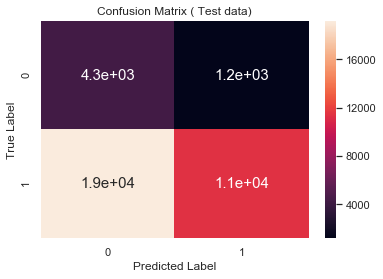

In [ ]:
matrix2 = confusion_matrix(y_test, predict_with_best_threshold(y_test_pred, best_t))  # Plot the confusion matrix
sns.heatmap(matrix2,annot=True, annot_kws={"size": 15},cbar=True)   # heatmap of confusion matrix
plt.ylabel('True Label');
plt.xlabel('Predicted Label');
plt.title('Confusion Matrix ( Test data)');

In [ ]:
# Store data belonging to all  indices which are responsible for False positive result

all_false_positive = []
for e in range(len(y_test)):
    if y_test[e] == 0 and y_pred_with_best_t[e] ==1 :
        all_false_positive.append(e)

In [ ]:
# Store data belonging to all  indices which are responsible for False positive result

essay_falsepositive = []
price_falsepositive = []
teacher_previous_posted_falsepositive = []

for e in tqdm(all_false_positive) :
    essay_falsepositive.append(data['essay'].values[e])  # append the data responsibe for false positives
    price_falsepositive.append( list(data['price'].values)[e] )
    teacher_previous_posted_falsepositive.append( list( data['teacher_number_of_previously_posted_projects'].values)[e])

#### Plot Word Cloud ::

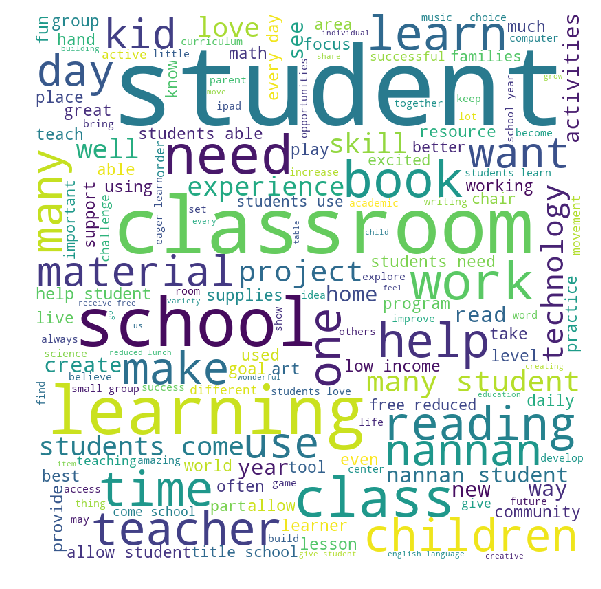

In [ ]:
from wordcloud import WordCloud,STOPWORDS
import matplotlib.pyplot as plt 
stopwords = set(STOPWORDS)
wordcloud = WordCloud(width = 800, height = 800, 
            background_color ='white', 
            stopwords = stopwords,    #By default, stopwords will be built in STOPWORDS
            min_font_size = 10).generate(' '.join(essay_falsepositive))   # joins all the essay related to false positives and then gives the wordcloud

plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show()

#### Box plot of prices in false positives :

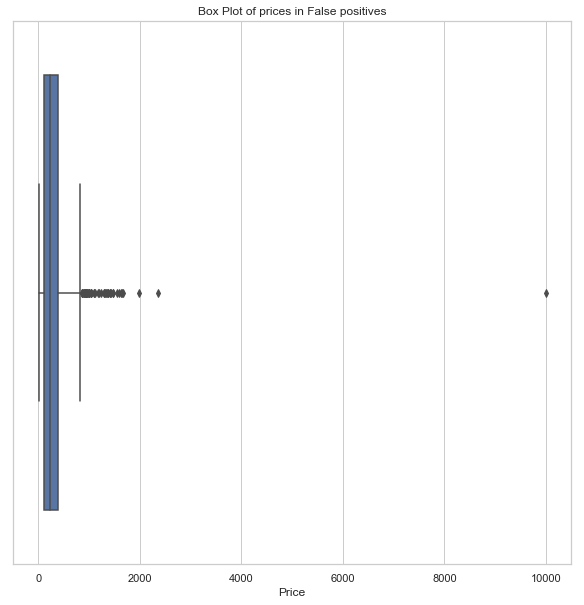

In [ ]:
plt.figure(figsize=(10,10))
sns.set(style="whitegrid")
ax = sns.boxplot(x=price_falsepositive)
ax.set(xlabel='Price', title='Box Plot of prices in False positives')
plt.show()

#### PDF of teacher_number_of_previously_posted_projects ::


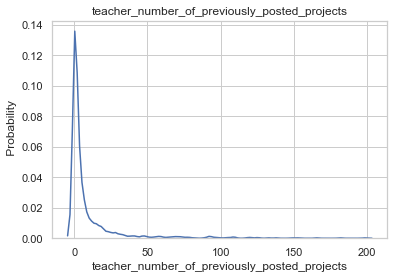

In [ ]:
ax = sns.kdeplot(teacher_previous_posted_falsepositive, cumulative= False)
ax.set(xlabel='teacher_number_of_previously_posted_projects', ylabel=' Probability', title='teacher_number_of_previously_posted_projects')
plt.show()

<h2>1.6 Getting top features using `feature_importances_`</h2>

In [ ]:
# Concatenating all features in order , so as to get the actual features, whcih is responsible for better classification

clf = DecisionTreeClassifier( max_depth=None  ,min_samples_split=best_split,class_weight = 'balanced'  )    # Important features with max_depth = None
clf.fit(X_tr,y_train)

final_features = tuple( essay_vocab + school_vocab + teacher_prefix_vocab + project_grade_vocab + clean_categories_vocab + clean_sub_categories_vocab + ['teacher_number_of_previously_posted_projects' ,'price'])

In [ ]:
all_features = sorted(zip(clf.feature_importances_ , final_features ), reverse= True)

In [ ]:
## Top Non Zero important features
top_features = [ i[1] for i in all_features if i[0]!=0.0  ]

## Task 2

In [ ]:
top_features_fit = CountVectorizer()   

In [ ]:
top_features_fit.fit(top_features)        # Using top features to encode all text data

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

### Encoding essay:

In [ ]:
#transforming essay

train_essay = top_features_fit.transform(X_train['essay'].values)
cv_essay = top_features_fit.transform(X_cv['essay'].values)
test_essay =  top_features_fit.transform(X_test['essay'].values)

### Encoding Categorical features ::

#### 1) Encoding school_state


In [ ]:
#transforming school_state

train_school_state = top_features_fit.transform(X_train['school_state'])
cv_school_state = top_features_fit.transform(X_cv['school_state'])
test_school_state = top_features_fit.transform(X_test['school_state'])

#### 2) Encoding teacher prefix

In [ ]:
#transforming teacher_prefix

train_teacher_prefix = top_features_fit.transform(X_train['teacher_prefix'])
cv_teacher_prefix = top_features_fit.transform(X_cv['teacher_prefix'])
test_teacher_prefix = top_features_fit.transform(X_test['teacher_prefix'])

#### 3) Encoding project_grade_category

In [ ]:
#Transforming project_grade_category

train_project_grade_category = top_features_fit.transform(X_train['project_grade_category'])
cv_project_grade_category = top_features_fit.transform(X_cv['project_grade_category'])
test_project_grade_category = top_features_fit.transform(X_test['project_grade_category'])

#### 4) clean_categories

In [ ]:
#Transforming clean_categories

train_clean_categories = top_features_fit.transform(X_train['clean_categories'])
cv_clean_categories = top_features_fit.transform(X_cv['clean_categories'])
test_clean_categories = top_features_fit.transform(X_test['clean_categories'])

#### 5) clean_subcategories

In [ ]:
#Transforming clean_subcategories

train_clean_subcategories = top_features_fit.transform(X_train['clean_subcategories'])
cv_clean_subcategories = top_features_fit.transform(X_cv['clean_subcategories'])
test_clean_subcategories = top_features_fit.transform(X_test['clean_subcategories'])

### Encoding Numerical Features

#### 1) Teacher_number_of_previously_posted_projects

In [ ]:
#Normalizing data using the Minmax scalar()
# Standardizing price does not make more sense, as the resultant may be having negative values.

scaler = MinMaxScaler()

scaler.fit(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1, 1))

train_teacher_previously_submitted_number_normalized = scaler.transform(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1, 1))
cv_teacher_previously_submitted_number_normalized  = scaler.transform(X_cv['teacher_number_of_previously_posted_projects'].values.reshape(-1, 1))
test_teacher_previously_submitted_number_normalized  = scaler.transform(X_test['teacher_number_of_previously_posted_projects'].values.reshape(-1, 1))

In [ ]:
print('X_train shape :: ',train_teacher_previously_submitted_number_normalized.shape)
print('X_cv shape :: ',cv_teacher_previously_submitted_number_normalized.shape)
print('X_test shape :: ',test_teacher_previously_submitted_number_normalized.shape)

X_train shape ::  (49041, 1)
X_cv shape ::  (24155, 1)
X_test shape ::  (36052, 1)


#### 2) price


In [ ]:
#Normalizing data using the Minmax scalar()
# Standardizing price does not make more sense, as the resultant may be having negative values.

scaler = MinMaxScaler()
scaler.fit(X_train['price'].values.reshape(-1, 1))

train_price_norm = scaler.transform(X_train['price'].values.reshape(-1,1))
cv_price_norm = scaler.transform(X_cv['price'].values.reshape(-1,1))
test_price_norm = scaler.transform(X_test['price'].values.reshape(-1,1))

print('X_train shape :: ',train_price_norm.shape)
print('X_cv shape :: ' , cv_price_norm.shape)
print('X_test shape::' , test_price_norm.shape)

X_train shape ::  (49041, 1)
X_cv shape ::  (24155, 1)
X_test shape:: (36052, 1)


In [ ]:
from scipy.sparse import hstack,vstack

X_tr = hstack((train_essay,    train_school_state,    train_teacher_prefix,    train_project_grade_category ,   train_teacher_previously_submitted_number_normalized ,  train_clean_categories ,   train_clean_subcategories  , train_price_norm)).tocsr()
X_cr = hstack((cv_essay,    cv_school_state,    cv_teacher_prefix,    cv_project_grade_category ,   cv_teacher_previously_submitted_number_normalized ,  cv_clean_categories ,   cv_clean_subcategories  , cv_price_norm)).tocsr()
X_te = hstack((test_essay,    test_school_state,    test_teacher_prefix,    test_project_grade_category ,   test_teacher_previously_submitted_number_normalized ,  test_clean_categories ,   test_clean_subcategories  , test_price_norm)).tocsr()

### 2)Hyper paramter tuning 

### Logistic regression

In [ ]:
from sklearn.linear_model import LogisticRegression

train_auc = []                # A list to hold the train auc scores
cv_auc = []                     # A list to hold the test auc scores

c = [0.1 , 0.001, 0.00001, 1, 10, 25, 100]

for c in tqdm(c ):                                                                   # Iterate through all the  values
    
    clf = LogisticRegression(C= c,class_weight='balanced')
    clf.fit(X_tr, y_train)
    
    y_train_pred = clf.predict_proba( X_tr)[:,1]                                        # Predict on Train set
    y_cv_pred = clf.predict_proba( X_cr)[:,1]                                            # Predict of Test set
    
    train_auc.append(roc_auc_score(y_train,y_train_pred))         # Append the scores to the appropriate lists.
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))


In [ ]:
print(train_auc)
print(cv_auc)

# We can see from the second value from both train and cv auc , that the differences are not much. 
# Therefor picking , c = 0.001

[0.7582936760246859, 0.732997778004219, 0.6610619662321489, 0.7597034866730571, 0.7598410350946674, 0.7598476978137512, 0.759851156991362]
[0.6973874319437796, 0.6960530080193769, 0.6470395492408565, 0.6987149856460382, 0.6989369138316461, 0.6989586984389495, 0.6989661956522406]


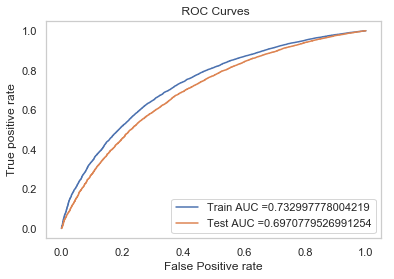

In [ ]:
# Training Train data set on the best parameter
clf = LogisticRegression(C= 0.001,class_weight= 'balanced')
clf.fit(X_tr,y_train)
 
y_train_pred = clf.predict_proba( X_tr)[:,1]   
y_test_pred = clf.predict_proba( X_te)[:,1]

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("False Positive rate")
plt.ylabel("True positive rate")
plt.title(" ROC Curves")
plt.grid()
plt.show()

<h1>2. Summary</h1>

In [ ]:
from prettytable import PrettyTable
x = PrettyTable(header = True, left_padding_width  = 10, right_padding_width  = 5 )
x.field_names = ["Vectorizer","Classifier","Model", "Best-Depth", "Best-Split","AUC"]
x.add_row(["Tifidf-W2V","Decision Tree", "Brute", 5, 10, 0.63333])
x.add_row(["TFIDF","Decision Tree", "Brute ",5, 10 ,0.6369])

x1 = PrettyTable(header = True, left_padding_width  = 10, right_padding_width  = 5 )
x1.field_names = ["Vectorizer","Classifier","Model", "Hyperparameter","AUC"]
x1.add_row(["Bestfeatures","Logistic regression", "Brute ",0.001 ,0.6953])
print('***** ' * 25)
print('***** ' * 25)
print('Decision Tree::')
print(x)
print('***** ' * 25)
print('***** ' * 25)
print('Logistic Regression ::')
print(x1)
print('***** ' * 25)
print('***** ' * 25)

***** ***** ***** ***** ***** ***** ***** ***** ***** ***** ***** ***** ***** ***** ***** ***** ***** ***** ***** ***** ***** ***** ***** ***** ***** 
***** ***** ***** ***** ***** ***** ***** ***** ***** ***** ***** ***** ***** ***** ***** ***** ***** ***** ***** ***** ***** ***** ***** ***** ***** 
Decision Tree::
+-------------------------+----------------------------+---------------------+-------------------------+-------------------------+----------------------+
|          Vectorizer     |            Classifier      |          Model      |          Best-Depth     |          Best-Split     |            AUC       |
+-------------------------+----------------------------+---------------------+-------------------------+-------------------------+----------------------+
|          Tifidf-W2V     |          Decision Tree     |          Brute      |              5          |              10         |          0.63333     |
|            TFIDF        |          Decision Tree     |          

### Reference ::

1) https://plot.ly/python/3d-scatter-plots/

2) https://stackoverflow.com/questions/58188816/plotly-set-line-color

3) https://plot.ly/python/reference/#scatter-line-color

4) https://www.datacamp.com/community/tutorials/wordcloud-python

5) https://stackoverflow.com/questions/31632637/label-axes-on-seaborn-barplot

6) https://stackoverflow.com/questions/39297523/plot-cdf-cumulative-histogram-using-seaborn-python

7) https://datascience.stackexchange.com/questions/31406/tree-decisiontree-feature-importances-numbers-correspond-to-how-features

8) https://stackoverflow.com/questions/9163407/svm-implmentation-scikits-learn-reducing-runtime-fastest-svm?rq=1

9) https://stackoverflow.com/questions/47469458/cache-size-effect-on-svc-processing-time

10)  http://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/